In [ ]:
import numpy as np
import matplotlib.pyplot as plt

GenerNahodCisel = np.random.default_rng(123456789123456789)

# Cvičení 4: $QR$ faktorizace matice


---
- [poznámky z přednášky](https://www.karlin.mff.cuni.cz/~blechta/znm/assets/OG_transformace.pdf)
- další materiály
  - kniha [Duintjer Tebbens a kolektiv: Analýza metod pro maticové výpočty](https://cuni.primo.exlibrisgroup.com/discovery/fulldisplay?docid=alma990020832750106986&context=L&vid=420CKIS_INST:UKAZ&lang=cs&search_scope=MyInst_and_CI&adaptor=Local%20Search%20Engine&tab=Everything&query=any,contains,Anal%C3%BDza%20metod%20pro%20maticov%C3%A9%20v%C3%BDpo%C4%8Dty&offset=0) (Kapitola 3)
  - skripta [Barto, Tůma: Lineární algebra](https://www.mff.cuni.cz/data/web/obsah/department_math/ka/skripta_la7.pdf) (Sekce 8.4)
  - skripta [Foundations of Applied Mathematics](https://foundations-of-applied-mathematics.github.io/) (Volume 1, Kapitola 4)

- ***Primární úlohy*** : A1, B1, B2

- ***Úlohy k bonusové části zkoušky*** : B1, B2, C1, C2

- základní ***Learning outcomes*** (cviko, nikoliv přednáška)
  - Umím vysvětlit rozdíl mezi klasickou a modifikovanou implementací Gram-Schmidtova procesu.
  - Umím porovnat výpočetní náročnost i kvalitu 4 postupů pro $QR$ faktorizaci matice (cGS, mGS, Householder, Givens).
  - Umím vysvětlit 2 ekvivalentní postupy použití $QR$ faktorizace matice k vyřešení $A\mathbf{x}=\mathbf{b}$ a porovnat jejich efektivitu.
  - Umím porovnat použití $QR$ faktorizace a $LU$ faktorizace coby nástrojů k řešení $A\mathbf{x}=\mathbf{b}$.
---

## Intro


V 2. cvičení, jsme viděli, že Gaussova eliminace s částečnou pivotací (a jí ekvivalentní algoritmus LU-faktorizace s částečnou picotací) jsou numericky pouze ***podmíněně stabilní*** - tedy může se stát, že výsledky jimi spočtené jsou naprosto špatně. Přestože se v mnoha aplikacích tyto metody používají, je vhodné znát i metody, které jsou ***nepodmíněně stabilní***.

Viděli jsme, že nestabilita Gaussovy eliminace pro $A\mathbf{x} = \mathbf{b}$ pramení z používání transformací na $A$, které mohou výrazně měnit normu objektu, který transformují -- v případě Wilkinsonovy matice tyto transformace odpovídali sčítání prvků ve vektoru.

Proto dává smysl snažit se namísto těchto používat transformace ***unitární***, tj. takové, které normu nemění vůbec. Odtud tedy plyne nápad, že by bylo dobré umět spočítat [***QR-faktorizaci***](https://en.wikipedia.org/wiki/QR_decomposition) matice $A$, tj, spočíst matice $Q$ a $R$ takové, že

$$ A = QR $$

a zároveň

  - $Q$ je ***unitární***, tj. $\forall \, \mathbf{v} \,:\, \|Q\mathbf{v}\|_2 = \|\mathbf{v}\|_2 $,
  - $R$ je ***horní trojúhelníková***.


Na přednášce jsme viděli celkem 4 algoritmy, které tuto faktorizaci počítají.


## Část A - [Gram-Schmidt](https://en.wikipedia.org/wiki/Gram%E2%80%93Schmidt_process#)


>Je to algoritmus, který znáte z lingebry1, kde jste ho používali na ortogonalizaci posloupnosti vektorů, ale měli jste jako aplikaci zmíněnou právě i QR-faktorizaci matice a souvislost s výpočtem ortonormální báze prostoru $\mathrm{Im}(A)$. Tento algoritmus má několik verzí a mi jsme se bavili o [klasické a modifikované verzi](https://dspace.mit.edu/bitstream/handle/1721.1/75282/18-335j-fall-2006/contents/lecture-notes/lec5handout6pp.pdf). Princip obou verzí je stejný - vezmeme si sloupce matice $A$ jako bázi prostoru $\mathrm{Im}(A)$ a postupně vektory této báze ortogonalizujeme vůči předchozím pomocí odečítání projekcí na již spočtenou část této báze.
>
>Pokud již máme spočítaných prvních $k$ vektorů $\mathbf{q}_1, \ldots, \mathbf{q}_{k}$ pomocí Gram-Schmidta, tj. platí
>
>$$
\mathbf{q}_1,\dotsc , \mathbf{q}_k \mathrm{\; tvori \; ON \; bazi}
\qquad \& \qquad
\mathrm{span} \{A_{:,1},\dotsc ,A_{:,k}\} = \mathrm{span} \{ \mathbf{q}_1,\dotsc , \mathbf{q}_k \},
$$
>
>pak $\mathbf{q}_{k+1}$ získáme jako
>
>$$
\mathbf{z} :=
A_{:,k+1} - \sum\limits_{i = 1}^{k} \mathbf{q}_i \mathbf{q}_i^T A_{:,k+1} =
\underbrace{ \, \left(I-\sum\limits_{i = 1}^{k} \mathbf{q}_i \mathbf{q}_i^T \right) A_{:,k+1} \,}_{\mathrm{klasicky \; GS}} \; = \;
\underbrace{ \, \prod\limits_{i=1}^{k} \left( I - \mathbf{q}_i \mathbf{q}_i^T \right) A_{:,k+1} \,}_{\mathrm{modifikovany \; GS}}
\quad \& \quad
\mathbf{q}_{k+1} = \mathbf{z} / \|\mathbf{z}\|_2.
$$
>
>V ***klasické verzi*** celý algoritmus stojí na počítání skalárních součinů
>$$
r_{i,k+1} := \mathbf{q}_i^T A_{:,k+1}
\qquad \mathrm{a \; pak} \qquad
\mathbf{z} := A_{:,k+1} - \sum\limits_{i = 1}^{k} \mathbf{q}_i r_{i,k}.
$$
>
> Vidíme, že výpočet všech skalárních součinů, tj. výpočet všech koeficientů $r_{i,k}$, může probíhat nezávisle na sobě, tj. *parallelně*.
>
>V ***modifikované verzi*** vše stojí na *sekvenčním* výpočtu
>
> - $r_{1,k+1} := \mathbf{q}_1^T A_{:,k+1} \quad \mathrm{a} \quad \mathbf{v}_1:=A_{:,k+1} - \mathbf{q}_{1}r_{1,k+1}$,
> - $r_{2,k+1} := \mathbf{q}_2^T \mathbf{v}_1 \quad \mathrm{a} \quad \mathbf{v}_2:= \mathbf{v}_1 - \mathbf{q}_2 r_{2,k+1}$,
> - $r_{3,k+1} := \mathbf{q}_3^T \mathbf{v}_2 \quad \mathrm{a} \quad \mathbf{v}_3:= \mathbf{v}_2 - \mathbf{q}_3 r_{2,k+1}$,
> - $\dotsc$
> - $r_{k,k+1} := \mathbf{q}_{k}^T \mathbf{v}_{k-1} \quad \mathrm{a} \quad \mathbf{v}_k:= \mathbf{v}_{k-1} - \mathbf{q}_k r_{k,k+1}$
> - a až nakonec $\mathbf{z} := \mathbf{v}_k$
>
>Označíme-li $r_{k+1,k+1} := \|\mathbf{z}\|_2$, pak dostaneme pro obě verze (stejně jako na přednášce)
>
>$$
A_{:,k+1} = \sum_{i = 1}^{k} r_{i,k+1} \mathbf{q}_i + r_{k+1,k+1} \ \mathbf{q}_{k+1}, \quad k=1,\ldots ,m,
$$
>
>neboli $A = QR$.


### Úloha A1 - implementace G-S

---
**Kódění** : Naprogramujte obě varianty výpočtu QR-faktorizace matice $A$ pomocí Gram-Schmidtova ortogonalizačního procesu.

  - "Pozor na python!" - pokud máme matici `A`, zadefinujeme si `z` jako její první sloupec `z = A[:,0]` a provedeme kód `z -= 1`, pak ***tím měníme i původní matici `A` - konkrétně `A[:,0]` na `A[:,0] - 1`***. Stejně se chová i příkaz `z[:] = z - 1`.
  - V pythonu příkaz `z = A[:,0]` nevytvoří kopii `A[:,0]` (tj. nealokuje konkrétní bity k uložení `z` a neokopíruje tam hodnoty vektoru `A[:,0]`). Namísto toho si uloží `z` jako "paměťový odkaz" a při každé operaci s `z` provede kýženou operaci s daty uloženými na "daném paměťovém odkazu".
  - Přirozeně při Gram-Schmidtovy, Househodlerovi ani Givensovy nechceme přepisovat matici $A$ - pak byste mohli mít správně kód, ale test (který se kouká, jestli platí $A=QR$) by ho označil ze špatný!
  - Pokud chci tomuto předejít můžu
    - *(i)* napsat `z = np.copy( A[:,0] )`. To donutí python opravdu alokovat nové bity pro novou proměnou `z` a tam zkopírovat hodnoty `A[:,0]`. Tímto se zpřetrhá ta vazba mezi `z` a `A[:,0]` a už si nadále jdou svými vlastními cestami.
    - nebo *(ii)* místo `z -= 1` nebo `z[:] = z - 1` napsat `z = z - 1`. To  také python donutí alokovat nové bity pro novou proměnou `z`. Tímto se také zpřetrhají vazby mezi `z` a `A[:,0]` a už si nadále jdou svými vlastními cestami.

----

In [ ]:
def qr_KlasickyGramSchmidt(A):
    """
    QR rozklad implementovany pomoci **klasicke** verze Gram-Schmidtovy ortogonalizace.

    Input
    -------
    A : np.array dimenze "m-krat-n" s prvky np.float64. Matice rozmeru m-krat-n

    Output
    -------
    Q : np.array dimenze "m-krat-min(m,n)" s prvky np.float64. Ortogonalni matice, sloupce tvori ON bazi linearniho obalu sloupcu A
    R : np.array dimenze "min(m,n)-krat-n" s prvky np.float64. Horni trojuhelnikova matice tak, aby A = QR
    """
    m, n = A.shape; Q = np.zeros((m,np.min([m,n]))); R = np.zeros((np.min([m,n]),n))

    for j in range(0,n):

      z = np.copy(A[:,j])
      NaKolikPredchozichVektoruProjektuju = np.min( [j,m] )

      for i in range(0,NaKolikPredchozichVektoruProjektuju):
          R[i,j] = np.dot(z,Q[:,i])

      if NaKolikPredchozichVektoruProjektuju < m :
        for i in range(0,NaKolikPredchozichVektoruProjektuju):
            z = z - R[i,j] * Q[:,i]
        R[j,j] = np.linalg.norm(z, 2)
        Q[:,j] = z/R[j,j]

    return Q, R


##############################################################
def test_qr_KlasickyGramSchmidt():
  all_m = np.linspace(2, 100, 10, dtype=np.int32); all_n = np.linspace(2, 100, 10, dtype=np.int32)

  for m in all_m:
    for n in all_n:
      A = np.random.rand(m, n)
      Q, R = qr_KlasickyGramSchmidt(A)
      assert np.allclose( A , Q @ R ), "A != QR, A je tvaru {}-krat-{}, QR je tvaru {}-krat-{}".format(m, n, Q.shape[0], Q.shape[1])
  return "test_qr_KlasickyGramSchmidt OK"
test_qr_KlasickyGramSchmidt()

'test_qr_KlasickyGramSchmidt OK'

In [ ]:
def qr_ModifikovanyGramSchmidt(A):
    """
    QR rozklad implementovany pomoci **modifikovane** verze Gram-Schmidtovy ortogonalizace.

    Input
    -------
    A : np.array dimenze "m-krat-n" s prvky np.float64. Matice rozmeru m-krat-n

    Output
    -------
    Q : np.array dimenze "m-krat-min(m,n)" s prvky np.float64. Ortogonalni matice, sloupce tvori ON bazi linearniho obalu sloupcu A
    R : np.array dimenze "min(m,n)-krat-n" s prvky np.float64. Horni trojuhelnikova matice tak, aby A = QR
    """
    m, n = A.shape; Q = np.zeros((m,np.min([m,n]))); R = np.zeros((np.min([m,n]),n))

    for j in range(0,n):

      z = np.copy(A[:,j])
      NaKolikPredchozichVektoruProjektuju = np.min( [j,m] )

      for i in range(0,NaKolikPredchozichVektoruProjektuju):
        R[i,j] = np.dot(z,Q[:,i])
        z = z - R[i,j] * Q[:,i]

      if NaKolikPredchozichVektoruProjektuju < m :
        R[j,j] = np.linalg.norm(z, 2)
        Q[:,j] = z/R[j,j]

    return Q, R


##############################################################
def test_qr_ModifikovanyGramSchmidt():
  all_m = np.linspace(2, 100, 10, dtype=np.int32); all_n = np.linspace(2, 100, 10, dtype=np.int32)

  for m in all_m:
    for n in all_n:
      A = np.random.rand(m, n)
      Q, R = qr_ModifikovanyGramSchmidt(A)
      assert np.allclose( A , Q @ R ), "A != QR, A je tvaru {}-krat-{}, QR je tvaru {}-krat-{}".format(m, n, Q.shape[0], Q.shape[1])
  return "test_qr_ModifikovanyGramSchmidt OK"
test_qr_ModifikovanyGramSchmidt()

'test_qr_ModifikovanyGramSchmidt OK'

## ZÚ - [Householderovy reflexe](https://en.wikipedia.org/wiki/Householder_transformation)




> Idea je vcelku jednoduchá - jako u Gaussovy eliminace chceme postupně vynulovat všechny nenulové prvky pod diagonálou, sloupec po sloupci. Pokud to ale budeme dělat pomocí ortogonálních transformací (tj. unitárních matic), bude nutně naše transformační matice unitární a tedy dostaneme QR-faktorizaci původní matice.
>
> Transformací, kterou na vynulovávání použijeme, je ***zrcadlení/reflexe*** vektoru - zjevně také nemění normu a je vždy možné najít nadrovinu tak, aby se daný vektor $\mathbf{x}\in\mathbb{R}^n$ zreflektoval na $\|\mathbf{x}\|_2 \cdot \mathbf{e}_1$. Na přednášce jsme si odvodili, že matice, která této reflexi odpovídá je dána jako
>
>
>$$
H = I_n - 2\cdot \mathbf{q}\mathbf{q}^T,
\qquad \mathrm{kde} \qquad
\mathbf{q} := \frac{ \mathbf{x} + \mathrm{sign}(x_1)\cdot \|\mathbf{x}\|_2 \cdot \mathbf{e}_1 }{ \| \mathbf{x} + \mathrm{sign}(x_1)\cdot \|\mathbf{x}\|_2 \cdot \mathbf{e}_1 \|_2 }.
$$

### Úloha 1

---
**Kódění** : Naprogramujte výpočet QR-faktorizace matice $A$ pomocí Householderových reflexí.

----

In [ ]:
def qr_Householder(A):
    """
    QR rozklad implementovany pomoci Householderovych reflexi.

    Input
    -------
    A : np.array dimenze "m-krat-n" s prvky np.float64. Matice rozmeru m-krat-n

    Output
    -------
    Q : np.array dimenze "m-krat-m" s prvky np.float64. Ortogonalni matice, sloupce tvori ON bazi linearniho obalu sloupcu A
    R : np.array dimenze "m-krat-n" s prvky np.float64. Horni trojuhelnikova matice tak, aby A = QR
    """

##############################################################
def test_qr_Householder():
  all_m = np.linspace(10, 100, 10, dtype=np.int32); all_n = np.linspace(10, 100, 10, dtype=np.int32)

  for m in all_m:
    for n in all_n:
      A = np.random.rand(m, n)
      Q, R = qr_Householder(A)
      assert np.allclose( A , Q @ R ), "A != QR, A je tvaru {}-krat-{}, QR je tvaru {}-krat-{}".format(m, n, Q.shape[0], Q.shape[1])
  return "test_qr_Householder OK"
test_qr_Householder()

'test_qr_Householder OK'

## [Givensovy rotace](https://en.wikipedia.org/wiki/Givens_rotation)

>Idea je stejná jako u Householderových reflexích - postupně vynulováívat všechny nenulové prvky pod diagonálou, sloupec po sloupci pomocí ortogonálních transformací (tj. unitárních matic).
>
> Transformací, kterou na vynulování použijeme, je ***rotace*** vektoru - rotace zjevně nemění normu a je zjevně vždy možné zrotovat daný vektor $[x_1,x_2]^T$ na vektor, který má jednu nulovou souřadnici (a stejnou normu), tj. na vektor  $[\sqrt{x_1^2 + x_2^2},0]^T$. Vhodnou posloupností rotací (což bude sama o sobě taky rotace) jsme tedy schopni transformovat vektor
>
>$$
\mathbf{x} := \begin{bmatrix} x_1 \\ x_2 \\ x_3 \\ \vdots \\ x_n \end{bmatrix}
\underbrace{\quad \rightarrow \quad}_{\mathrm{rotace\;} R_{1}}
\begin{bmatrix} \sqrt{x_1^2 + x_2^2} \\ 0 \\ x_3 \\ \vdots \\ x_n \end{bmatrix}
\underbrace{\quad \rightarrow \quad}_{\mathrm{rotace\;} R_{2}}
\dotsc
\underbrace{\quad \rightarrow \quad}_{\mathrm{rotace\;} R_{n-1}}
\begin{bmatrix} \|\mathbf{x}\|_2 \\ 0 \\ 0 \\ \vdots \\ 0 \end{bmatrix}.
$$
>
> Matice odpovídající rotacím $R_1,\dotsc ,R_{n-1}$ se kalsicky značí $G_1,\dotsc ,G_{n-1}$ a mají přímočaře odvoditelný tvar, který jsme si na přednášce ukázali:
>
>$$
G_1 =
\begin{bmatrix}
c_1 & -s_1 \\
s_1 & c_1 \\
&& 1 \\
&&& \ddots \\
&&&& 1
\end{bmatrix}, \quad
G_2 =
\begin{bmatrix}
c_1 && -s_1 \\
 & 1 \\
s_1 && c_1 \\
&&& \ddots \\
&&&& 1
\end{bmatrix}, \quad \dotsc \in \mathbb{R}^{n\times n }
$$

In [ ]:
def qr_Givens(A):
    """
    QR rozklad implementovany pomoci Givensovych rotaci.

    Input
    -------
    A : np.array dimenze "m-krat-n" s prvky np.float64. Matice rozmeru m-krat-n

    Output
    -------
    Q : np.array dimenze "m-krat-m" s prvky np.float64. Ortogonalni matice, sloupce tvori ON bazi linearniho obalu sloupcu A
    R : np.array dimenze "m-krat-n" s prvky np.float64. Horni trojuhelnikova matice tak, aby A = QR
    """
    def GivensRotation(a, b):
        """ Vypocitame prvky "c" a "s" pro rotaci [a,b] na [+/-norm([a,b]),0]. Nezapomeňte ošetřit případy jako "a=0" a "b=0" """
        if b == 0:
            c = 1; s = 0
        elif a == 0:
            c = 0; s = 1
        elif abs(b) > abs(a):
            t = - a / b; s = 1 / np.sqrt(1 + t**2); c = s * t
        else:
            t = - b / a; c = 1 / np.sqrt(1 + t**2); s = c * t
        return np.array( [ [c, -s],[s, c] ] )

    m, n = A.shape; Q = np.eye(m); R = A.copy()

    for j in range(0,np.min([m,n]) ):
        for i in range(m-1, j, -1):
            G = GivensRotation(R[i-1, j], R[i, j])
            inds_R = np.array([i-1,i])
            R[inds_R, :] = G @ R[inds_R, :]
            Q[:,inds_R] = Q[:,inds_R] @ G.T

    return Q[:,0:np.min([m,n])], R[0:np.min([m,n]),:]


##############################################################
def test_qr_Givens():
  all_m = np.linspace(10, 100, 10, dtype=np.int32); all_n = np.linspace(10, 100, 10, dtype=np.int32)

  for m in all_m:
    for n in all_n:
      A = np.random.rand(m, n)
      Q, R = qr_Givens(A)
      assert np.allclose( A , Q @ R ), "A != QR, A je tvaru {}-krat-{}, QR je tvaru {}-krat-{}".format(m, n, Q.shape[0], Q.shape[1])
  return "test_qr_Givens OK"
test_qr_Givens()

'test_qr_Givens OK'

## Část B: Který algoritmus vybrat?

Výše jsme si připomněli/nakódili několik způsobů jak spočíst $QR$-faktorizaci matice $A$ - přirozená otázka je, který bychom si měli v závislosti na matici $A$ vybrat? Porovnávat budeme
   - kvalitu výsledné $QR$-faktorizace
   - výpočetní náročnost daného postupu $QR$-faktorizace

### Úloha B1 - Kvalita


Dejme tomu, že pro danou matici $A\in \mathbb{R}^{m\times n}$ spočítáme její $QR$-faktorizaci jedním z algoritmů výše a dostaneme matice $\hat{Q}$ a $\hat{R}$.


První rozumný, způsob jak měřit kvalitu $QR$ faktorizace, je tzv. její ***relativní reziduum***, tj. norma $ \frac{ \| A - \hat{Q}\hat{R} \| }{ \| A \| }$.
  - pokud bychom měli velké reziduum, zjevně daný algoritmus nedělá to, co bychom chtěli;

Druhý způsob, jak měřit kvalitu $QR$ faktorizace, je tzv. ***ztráta ortogonality výsledné báze***, tj. norma $\| I - \hat{Q}^T\hat{Q} \|_F$.
  - na druhou stranu jsme chtělli algoritmus, který bude numericky stabilní (ne jako $LU$-faktorizace, aka Gaussova eliminace) - chtěli jsme algoritmus, který vytvoří ortonormální bazi.

Zjevně oba přístupy dávají v principu smysl, přestože měří zcela jiné věci - více o jejich porovnání je např. v [Duintjer Tebbens a kolektiv: Analýza metod pro maticové výpočty](https://cuni.primo.exlibrisgroup.com/discovery/fulldisplay?docid=alma990020832750106986&context=L&vid=420CKIS_INST:UKAZ&lang=cs&search_scope=MyInst_and_CI&adaptor=Local%20Search%20Engine&tab=Everything&query=any,contains,Anal%C3%BDza%20metod%20pro%20maticov%C3%A9%20v%C3%BDpo%C4%8Dty&offset=0)  (Sekce 3.5.5)



---
 **Kódění** : Otestujte numerické výsledky o stabilitě a ztrátě ortogonality našich 4 algoritmů.
  - konkrétně chceme vidět jak se vyvíjí reziduum $\| A - \hat{Q}\hat{R}\|_F$ a ztráta ortogonality matice $\hat{Q}$, tj. $\| I - \hat{Q}^T\hat{Q} \|_F$ v závislosti na čísle podmíněnosti $\kappa(A)$ matice $A \in \mathbb{R}^{n\times n}$.
  - matici `A` dimenze `n` s číslem podmíněnosti `CondNumb` lze sestavit za pomoci předdefinované funkce `RandomMatice(n,CondNumb)`.
  - vhodná volba testovacích hodnot je například `CondNmb_totry = np.logspace(0,20,30); n = 50`.

**Tužka a papír** :
  - na základě výsledků dovoďte závislost $\| A - \hat{Q}\hat{R}\|_F$ a $\| I - \hat{Q}^T\hat{Q} \|_F$ na $\kappa(A)$ jako explicitní funkci.

  - porovnejte s přednáškou/googlením/literaturou a okomentujte rozdíly nebo shodu.
----

---
***Řešení***
- vidíme, že v logaritmickém měřítku na obou osách se
  - $\| A - \hat{Q}\hat{R}\|_F$ chová přibližně jako konstantní funkce na úrovni $10^{-15} \approx n\cdot \varepsilon_{mach}$, téměř nezávisle na $\kappa(A)$ a to pro všechny 4 algoritmy.  
  - $\| I - \hat{Q}^T\hat{Q} \|_F$ se chová přibližně jako konstantní funkce na úrovni $10^{-15} \approx n\cdot \varepsilon_{mach}$ pro implementace skrze Householderovy reflexe a Givensovy rotace.
  - $\| I - \hat{Q}^T\hat{Q} \|_F$ se pro CGS chová přibližně jako lineární funkce a tedy očekáváme závislost typu $\| I - \hat{Q}^T\hat{Q} \|_F = \mathcal{O}(\kappa(A)^{\alpha})$ - viz cviko 2. Odečtením z grafu odhadneme $$\kappa(A)\approx 10^{2} \; \& \; \| I - \hat{Q}^T\hat{Q} \|_F\approx 10^{-13} \quad \mathrm{a} \quad \kappa(A)\approx 10^{5} \; \& \; \| I - \hat{Q}^T\hat{Q} \|_F\approx 10^{-7} $$
   a tedy dostáváme $\alpha\approx 2$.
  - $\| I - \hat{Q}^T\hat{Q} \|_F$ se pro MGS chová přibližně jako lineární funkce a tedy očekáváme závislost typu $\| I - \hat{Q}^T\hat{Q} \|_F = \mathcal{O}(\kappa(A)^{\alpha})$ - viz cviko 2. Odečtením z grafu odhadneme $$\kappa(A)\approx 10^{2} \; \& \; \| I - \hat{Q}^T\hat{Q} \|_F\approx 10^{-14} \quad \mathrm{a} \quad \kappa(A)\approx 10^{5} \; \& \; \| I - \hat{Q}^T\hat{Q} \|_F\approx 10^{-11} $$
   a tedy dostáváme $\alpha\approx 1$.

- Pozorování výše jsou v souladu s přednáškou. Naše odhady z grafů lze jednoduše přímo ověřit vypsáním a dosazenám spočtených hodnot.
---

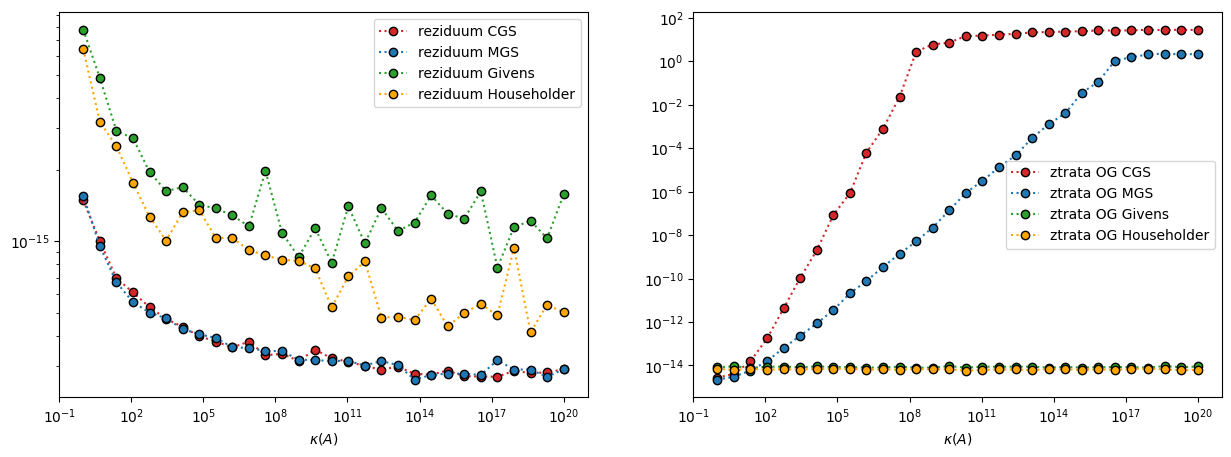

In [ ]:
def RandomMatice(n, cond):
    """ Vrati nesingularni ctvercovou matici A rozmeru "n"-krat-"n" s cislem podminenosti kappa(A) = "cond". """
    GenerNahodCisel = np.random.default_rng(123456789123456789) ### tenhle radek zajistuje, ze ty nahodnz cisla jsou vygenerovanz pri kazdem behu stejne (lze smazat)
    A = GenerNahodCisel.standard_normal(size=(n, n))
    U, _, Vt = np.linalg.svd(A)
    S = np.diag(np.logspace(0, -np.log10(cond), n))
    return U @ S @ Vt



CondNmb_totry = np.logspace(0,20,30); n = 50

reziduum_CGS = np.zeros(len(CondNmb_totry)); OG_CGS = np.zeros(len(CondNmb_totry))
reziduum_MGS = np.zeros(len(CondNmb_totry)); OG_MGS = np.zeros(len(CondNmb_totry))
reziduum_Givens = np.zeros(len(CondNmb_totry)); OG_Givens = np.zeros(len(CondNmb_totry))
reziduum_HH = np.zeros(len(CondNmb_totry)); OG_HH = np.zeros(len(CondNmb_totry))

In = np.eye(n)
for ind in range(0,len(CondNmb_totry)):

  A = RandomMatice(n, CondNmb_totry[ind])

  Q,R  = qr_KlasickyGramSchmidt(A)
  reziduum_CGS[ind] = np.linalg.norm(A - Q @ R, ord='fro'); OG_CGS[ind] = np.linalg.norm(In - Q.T @ Q, ord='fro')
  Q,R  = qr_ModifikovanyGramSchmidt(A)
  reziduum_MGS[ind] = np.linalg.norm(A - Q @ R, ord='fro'); OG_MGS[ind] = np.linalg.norm(In - Q.T @ Q, ord='fro')
  Q,R  = qr_Givens(A)
  reziduum_Givens[ind] = np.linalg.norm(A - Q @ R, ord='fro'); OG_Givens[ind] = np.linalg.norm(In - Q.T @ Q, ord='fro')
  ### zakomentovat, pokud ještě nemám nakóděného Householdera (zkratka "ctrl+/")
  # Q,R  = qr_Householder(A)
  # reziduum_HH[ind] = np.linalg.norm(A - Q @ R, ord='fro'); OG_HH[ind] = np.linalg.norm(In - Q.T @ Q, ord='fro')



#################################### Vykreslovani
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.loglog(CondNmb_totry, reziduum_CGS, 'o:', color='tab:red', markeredgecolor='k', label=r'reziduum CGS')
plt.loglog(CondNmb_totry, reziduum_MGS, 'o:', color='tab:blue', markeredgecolor='k', label=r'reziduum MGS')
plt.loglog(CondNmb_totry, reziduum_Givens, 'o:', color='tab:green', markeredgecolor='k', label=r'reziduum Givens')
if (reziduum_HH[0:3] != np.zeros(3)).all() :
  plt.loglog(CondNmb_totry, reziduum_HH, 'o:', color='orange', markeredgecolor='k', label=r'reziduum Householder')
plt.legend(); plt.xlabel(r'$\kappa(A)$');

plt.subplot(1,2,2)
plt.loglog(CondNmb_totry, OG_CGS, 'o:', color='tab:red', markeredgecolor='k', label=r'ztrata OG CGS')
plt.loglog(CondNmb_totry, OG_MGS, 'o:', color='tab:blue', markeredgecolor='k', label=r'ztrata OG MGS')
plt.loglog(CondNmb_totry, OG_Givens, 'o:', color='tab:green', markeredgecolor='k', label=r'ztrata OG Givens')
if (reziduum_HH[0:3] != np.zeros(3)).all() :
  plt.loglog(CondNmb_totry, OG_HH, 'o:', color='orange', markeredgecolor='k', label=r'ztrata OG Householder')
plt.legend(); plt.xlabel(r'$\kappa(A)$'); plt.show()
#################################### Vykreslovani

### Úloha B2 - Výpočetní náročnost

Pro pro měření času programu použijeme funkci [`%timeit -o -qq`](https://docs.python.org/3/library/timeit.html) :

  ```
  # nasledujici kod zmeri cas potrebny na exekuci funkce "MojeFunkce()"
  TimeResult = %timeit -o -qq MojeFunkce_output = MojeFunkce(MojeFunkce_input)
  print('Prumerny cas na exekuci "MojeFunkce()" je', TimeResult.average)
  print('Smerodatna odchylka exekuce "MojeFunkce()" je', TimeResult.stdev)

  # Funkce "%timeit" mnohokrat spusti zbytek radku po prikazu "%timeit" a udela jednoduchou statistiku casu.
  # Meren je cas celeho zbyleho radku, tj. vseho za prikazem "%timeit".
  # Obecne funkce "%timeit" vraci objekt (tj. nikoliv pouze cas).
  # V tomto objektu je property "average" - tj. "TimeResult.average" udava prumerny cas na exekuci.
  # prikaz "-o" zajistuje, ze funkce "%timeit" da vystup
  # prikaz "-qq" zajistuje, ze funkce "%timeit" nebude nic vypisovat
  ```

---
 **Kódění** : Otestujte časovou výpočetní náročnost našich 4 algoritmů.
  - konkrétně chceme vidět, jak dlouho trvá výpočet $QR$-faktorizace čtvercové matice $A \in \mathbb{R}^{n\times n}$.
  - regulární matici `A` dimenze `n` "bez speciálních vlastností" lze generovat jako výše, například `A = RandomMatice(n,10)`,
  - obrázek níže se vygeneruje volbou `n_totry = np.logspace(2,3,6, dtype=np.int32)`, ale ten kód pak běží cca 5 minut.
  - je vhodné si kód nejprve debuggovat, např. na hodnotách `n_totry = np.logspace(1,2,10, dtype=np.int32)`.

**Tužka a papír** :
  - na základě výsledků odhadněte závislost délky výpočtu $QR$-faktorizace na velikosti matice.
  - <details><summary>Chci <font color="red"><b>hint</b></font></summary>
    Předpokládejme, že máme funkci $y = g(x)>0$, kterou jsme vykreslili v logaritmickém měřítku an obou osách. Pokud vidíme, že takový graf rostoucí přímka s kladnými hodnotami, jaký vztah platí mezi $\log_{10} (g(x))$ a $\log_{10}(x)$? Jak pak vypadá $g(x)$? Porovnejte s Úlohou A2 z minulého cvičení.
    </details>

  - porovnejte s přednáškou/googlením.

----

---
***Řešení***

- vidíme, že výpočetní čas pro všechny čtyři algoritmy odpovídá v logaritmickém měřítku (na obou osách) přímkám, nadto přímkám se stejným sklonem. Tedy pro všechny algoritmy můžeme předpokládat časovou náročnost řádu $\mathcal{O}(\beta_{\star} n^{\alpha})$, kde $\beta_{\star}$ se liší pro jednotlivé algoritmy (např. $\beta_{CGS} \neq \beta_{Givens}$, ale řád $\alpha$ je pro všechny algoritmy stejný. To přesně odpovídá teorii z přednášky.

- odhadem z grafu dostáváme $\alpha \approx 2~2.2$. To naopak přednášce a obecné analýze výpočetní náročnosti vůbec neodpovídá - asymptoticky platí $\alpha=3$.

- Zároveň vidíme, že pro naše měření platí $\beta_{CGS, MGS} < \beta_{Householder,Givens}$.

- K rozporu našeho měření s přednáškou/teorií přispívá nejspíše několik faktorů - zmíníme dva důležité.
  - Na všech moderních počítačích probíhá k tzv. [*pipelining*](https://en.wikipedia.org/wiki/Instruction_pipelining), díky němuž mnoho operací, které jsou na papíře sekvenční probíhají na našem procesoru "trochu paralelně".
  - Mnoho základních operací/výpočtů je silně optimalizováno pro moderní počítače - například operace jako $\mathbf{v}^T\mathbf{w}, A\mathbf{v}$ nebo $AB$ a pro *relativně malé dimenze* jsou naše počítače schopné mnoho z těchto operací provést rychleji, než bychom čekali - například i díky pipeliningu (viz [*BLAS operace*](https://en.wikipedia.org/wiki/Basic_Linear_Algebra_Subprograms)).
  - Ani jednu z těchto vlastností nebudeme dále studovat, ale více se můžeme dozvědět třeba na [NMNV565: High-Performance Computing for Computational Science](https://is.cuni.cz/studium/predmety/index.php?do=predmet&kod=NMNV565) nebo [NMNV532: Paralelní maticové výpočty](https://is.cuni.cz/studium/predmety/index.php?do=predmet&kod=NMNV532).

---

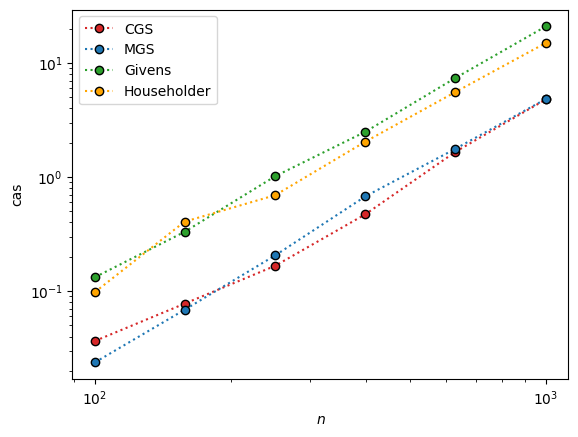

In [ ]:
n_totry = np.logspace(2,3,6, dtype=np.int32)

casy_CGS = np.zeros(len(n_totry)); casy_MGS = np.zeros(len(n_totry))
casy_Givens = np.zeros(len(n_totry)); casy_HH = np.zeros(len(n_totry))

for ind in range(0,len(n_totry)):
  n = n_totry[ind]
  A = RandomMatice(n,10)

  time_result = %timeit -o -qq  Q,R = qr_KlasickyGramSchmidt(A)
  casy_CGS[ind] = time_result.average

  time_result = %timeit -o -qq  Q,R = qr_ModifikovanyGramSchmidt(A)
  casy_MGS[ind] = time_result.average

  time_result = %timeit -o -qq  Q,R = qr_Givens(A)
  casy_Givens[ind] = time_result.average

  ### zakomentovat, pokud ještě nemám nakóděného Householdera (zkratka "ctrl+/")
  time_result = %timeit -o -qq  Q,R = qr_Householder(A)
  casy_HH[ind] = time_result.average



plt.loglog(n_totry,casy_CGS, 'o:', color='tab:red', markeredgecolor='k', label='CGS')
plt.loglog(n_totry,casy_MGS, 'o:', color='tab:blue', markeredgecolor='k', label='MGS')
plt.loglog(n_totry,casy_Givens, 'o:', color='tab:green', markeredgecolor='k', label='Givens')
plt.loglog(n_totry,casy_HH, 'o:', color='orange', markeredgecolor='k', label='Householder')
plt.legend(); plt.xlabel(r'$n$'); plt.ylabel(r'cas'); plt.show()

 ## Část C: Řešení soustav lineárních algebraických rovnic pomocí $QR$-faktorizace

Jedna z hlavních aplikací pro $QR$-faktorizaci matice je řešení soustav lineaárních algebraických rovnic, tj.

$$
A\mathbf{x} = \mathbf{b}.
$$

Stejně jako u předchozího cvika máme v principu dvě možnosti, které staví na QR faktorizaci.



### QR faktorizace $A$
> Tato metoda je vhodnější pokud víme, že chceme vyřešit několik lineárních systémů s maticí $A$, tj.
$$ A\mathbf{x}_1 = \mathbf{b}_1 , \dotsc , A\mathbf{x}_N = \mathbf{b}_N, $$
ale nemáme k dispozici všechny pravé strany $A\mathbf{b}_1, \dotsc , \mathbf{b}_1$. Pak se nám vyplatí si předpočítat faktory $Q$ a $R$ a následně pokaždé, když dostaneme další pravou stranu $\mathbf{b}_i$ ji transformujeme na $\tilde{\mathbf{b}}_i := Q^T\mathbf{b}_i$ a poté řešíme systém
>
> $$ R\mathbf{x}_i = \tilde{\mathbf{b}}_i.$$


### QR faktorizace $[A|\mathbf{b}]$
> Tato metoda je vhodnější pokud víme, že chceme vyřešit pouze jeden lineární systém s maticí $A$ a tedy není důvod si ukládat matici $Q$.
>
>Místo postupu výše můžeme aplikovat transformace (projektory v Gram-Schmidtovy, rotace u Givense nebo reflexe u Householdera) nejen na sloupce matice $A$ tak jak jsme zvyklí, ale zároveň i na vektor pravé strany $\mathbf{b}$. Mělo by být zjevné, že toto odpovídá QR faktorizaci matice
>
> $$ \tilde{Q} \tilde{R} =  [A|\mathbf{b}] \in\mathbb{R}^{n\times (n+1)},
\qquad \mathrm{kde} \qquad \tilde{Q}\in \mathbb{R}^{n\times n} \; \mathrm{a} \;  \tilde{R}\in \mathbb{R}^{n\times (n+1)},
$$
>
>podobně jako Gaussova eliminace odpovídá LU faktorizaci $[A|\mathbf{b}]$, kde $U$ faktor je "o jeden sloupec širší". Stejně tak i v tomto případě pak získáme řešení $\mathbf{x}$ původního problému řešením soustavy
>
>$$ \tilde{R}_{1:n,1:n}\mathbf{x} = \tilde{R}_{:,n+1}.$$



### Úloha C1

Uvažujme problém $A\mathbf{x}= \mathbf{b}$, kde $A\in \mathbb{R}^{n\times n}$ je regulární a zachovejme značení jako výše.

---
**Tužka a papír**: Ukažte, že oba postupy výše jsou matematicky ekvivalentní. Konkrétně, že platí
  - $Q = \tilde{Q}_{:,1:n}$,
  - $R = \tilde{R}_{:,1:n}$,
  - $Q^T\mathbf{b} = \tilde{R}_{:,n+1}$,
  a  tudíž soustavy výše mají stejné řešení $\mathbf{x}\in \mathbb{R}^n$.

----

---
***Řešení***

- $[A|\mathbf{b}] = \tilde{Q}\tilde{R}$ implikuje $A = \tilde{Q}\tilde{R}_{:,1:n}$ a $\mathbf{b} = \tilde{Q}\tilde{R}_{:,n+1}$. Pokud jsme použili stejný algoritmus/postup k výpočtu QR-faktorizace matic $A$ a $[A|\mathbf{b}]$, pak zjevně $\tilde{Q} = Q$ a tedy $\tilde{R}_{:,1:n} = R$ a $Q^T\mathbf{b} =\tilde{R}_{:,n+1}$ (přenásobíme rovnosti $A = \tilde{Q}\tilde{R}_{:,1:n}$ a $\mathbf{b} = \tilde{Q}\tilde{R}_{:,n+1}$ $Q^T$ zleva).

---

### Úloha C2

Vezmeme si matici $A\in \mathbb{R}^{m\times n}$ a její $QR$-faktorizaci $A=QR$. V úloze C1 jsme viděli, že pokud jde o řešení soustav algebraických rovnic, pak "$R$ podědí všechny důležité informace po $A$" - stačí nám řešit pozměněnou soustavu pouze s $R$. Co dalšího ta matice $R$ po $A$ podědí?

---
**Tužka a papír**: Ukažte, že platí
  - $\|A\|_2 = \|R\|_2$ a také $\|A\|_F = \|R\|_F$,
  - $\kappa(A) = \kappa(R)$.

----

---
***Řešení***

- $\|A\|_2= \max_{\|x\|=1}\|Ax\|_2$, tedy záleží na velikosti dvojkové vektorové normy, která se přenásobením vektoru unitární maticí nemění.
- Frobeniova maticová norma je odmocninou součtu kvadrátů velikosti dvojkových norem sloupců matice, argumentace je tak stejná, jako v předchozím případě, sloupce výsledné matice $R$ mají stejnou normu jako matice $A$ a tedy Frobeniova norma matice $R$ je stejná jako matice $A$.

---

### Úloha C3

Uvažujme problém $A\mathbf{x}= \mathbf{b}$, kde $A\in \mathbb{R}^{n\times n}$ a zachovejme značení jako výše. Vyzkoušíme, jestli "matematicky ekvivalentní" funguje i při reálném výpočtu.

---
**Kódění** :
- Nakóděte funkce `RelChyba(x_true, x_aprox)` a `RelReziduum(A, b, x_aprox)`, které počítají velikost relativní chyby $e_{rel}$ a relativního rezidua $r_{rel}$ daného numerické aproximace.

- Stejně jako v B1 budeme generovat matice $A$ s postupně rostoucím číslem podmíněnosti $\kappa(A)$. Vykreslete jak se bude vyvíjet $e_{rel}$ a $r_{rel}$ podle zvoleného typu výpočtu $QR$-faktorizace.
  - vhodná volba testovacích hodnot $\kappa(A)$ je například `CondNmb_totry = np.logspace(0,20,30); n = 50`.
  - otestujte obě verze aplikace QR faktorizace, tj. jako QR faktorizaci $A$ tak $[A|\mathbf{b}]$,
  - pro sestavování matic a vektorů "po blocích" se hodí [`np.block()`](https://numpy.org/doc/stable/reference/generated/numpy.block.html), ale lze použít také [`np.concatenate()`](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html).

  - Výsledky pečlivě okomentujte a zdůvodněte.
----

In [ ]:
def RelChyba(x_true, x_aprox):
    """ Spocitame relativni primou chybu pro danou aproximaci "x_aprox" a presne reseni "x_true". """
    # Vas kod
    return np.linalg.norm(x_true - x_aprox) / np.linalg.norm(x_true)

def RelReziduum(A, b, x_aprox):
    """ Spocitame relativni reziduum (aka zpetnou chybu) pro danou aproximaci "x_aprox" a problem zadany matici "A" a pravou stranou "b". """
    # Vas kod
    return np.linalg.norm(A @ x_aprox - b) / np.linalg.norm(b)

####################################################
def test_RelChybReziduum():
    x = np.arange(0,10,1)
    assert (RelChyba(x, x) < 1e-10 ), "RelChyba pro x_aprox = x_true by melo vratit 0"
    y = x + 1
    assert ( RelChyba(x, y) > 0 ), "RelChyba by melo vzdy vracet kladne hodnoty pro x_aprox != x_true"
    assert ( abs(RelChyba(x, y) - np.sqrt(10) / np.linalg.norm(x)) < 1e-8 ), "RelChyba je vypocitan spatne pro x_true = [1,2,3] a x_aprox = [2,3,4]"

    for n in [5, 10, 20]:
      A = np.random.normal(size=(n,n)); x_true = np.random.normal(size=n)
      b = A @ x_true; x_estim = x_true
      assert ( RelReziduum(A, b, x_estim) < 1e-10 ), "RelReziduum pro x_aprox = x_true by mel vratit 0"
      x_estim = np.random.normal(size=n)
      assert ( RelReziduum(A, b, x_estim) > 0 ), "RelReziduum by mel vzdy vracet kladne hodnoty pro A*x_aprox != b"
      A = np.eye(n); x_true = np.ones(n); b = A @ x_true; x_estim = x_true + 1
      assert ( abs(RelReziduum(A, b, x_estim) - 1) < 1e-8 ), "RelReziduum pro A jednotkovou matici, b=[1,1,1,1,1], x_aprox=[2,2,2,2,2] vraci spatny vysledek"
    return "'RelChyba()' & 'RelReziduum()' jsou OK"
test_RelChybReziduum()

"'RelChyba()' & 'RelReziduum()' jsou OK"

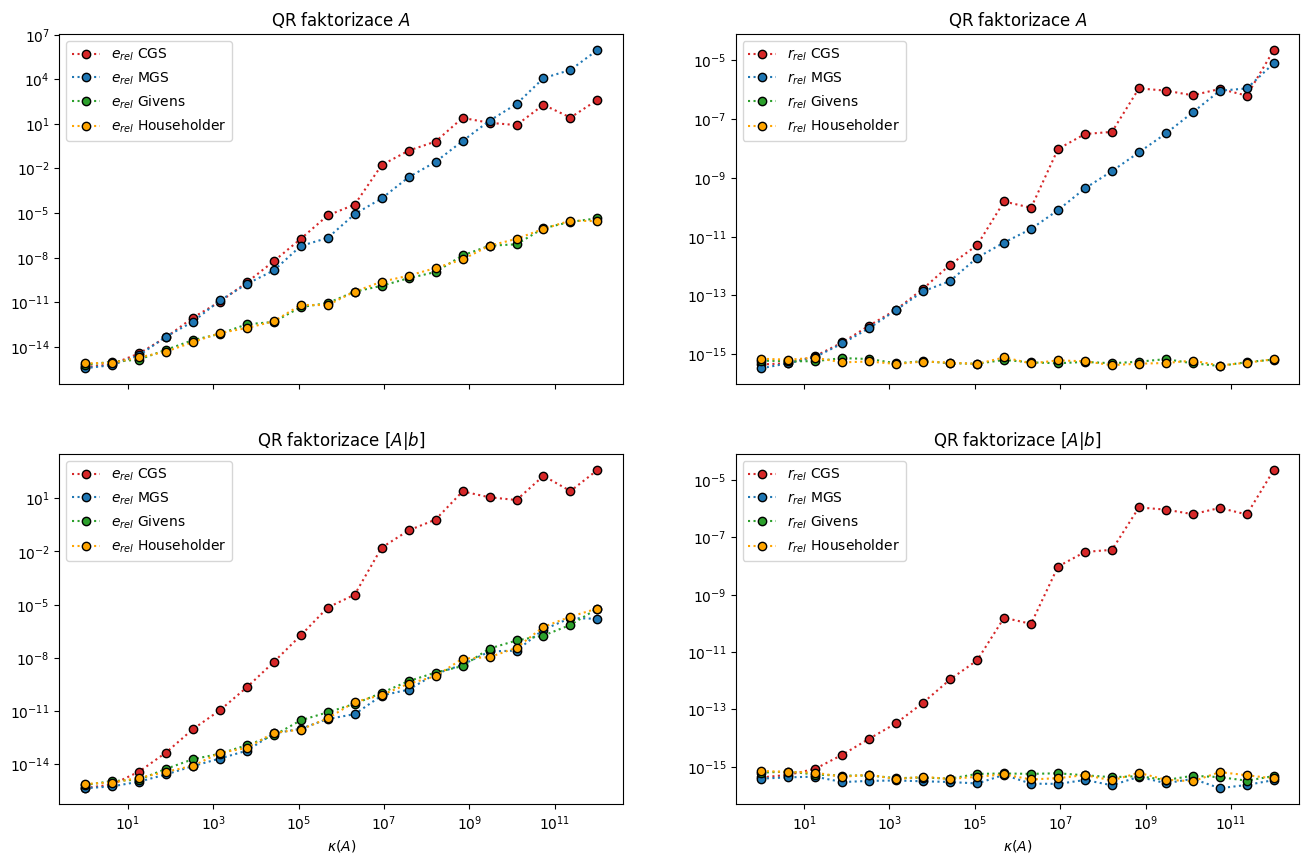

In [ ]:
def RandomMatice(n, cond):
    """
    Vrati nesingularni ctvercovou matici A rozmeru "n"-krat-"n" s cislem podminenosti kappa(A) = "cond".
    """
    A = GenerNahodCisel.standard_normal(size=(n, n))
    U, _, V = np.linalg.svd(A)
    S = np.diag(np.logspace(0, -np.log10(cond), n))
    return U @ S @ V

CondNmb_totry = np.logspace(0,12,20); n = 50

### inicializace pro qr(A)
ef_CGS_A = np.zeros(len(CondNmb_totry)); eb_CGS_A = np.zeros(len(CondNmb_totry))
ef_MGS_A = np.zeros(len(CondNmb_totry)); eb_MGS_A = np.zeros(len(CondNmb_totry))
ef_Givens_A = np.zeros(len(CondNmb_totry)); eb_Givens_A = np.zeros(len(CondNmb_totry))
ef_HH_A = np.zeros(len(CondNmb_totry)); eb_HH_A = np.zeros(len(CondNmb_totry))

### inicializace pro qr([A|b])
ef_CGS_Ab = np.zeros(len(CondNmb_totry)); eb_CGS_Ab = np.zeros(len(CondNmb_totry))
ef_MGS_Ab = np.zeros(len(CondNmb_totry)); eb_MGS_Ab = np.zeros(len(CondNmb_totry))
ef_Givens_Ab = np.zeros(len(CondNmb_totry)); eb_Givens_Ab = np.zeros(len(CondNmb_totry))
ef_HH_Ab = np.zeros(len(CondNmb_totry)); eb_HH_Ab = np.zeros(len(CondNmb_totry))


for ind in range(0,len(CondNmb_totry)):

  A = RandomMatice(n, CondNmb_totry[ind])
  x_true = GenerNahodCisel.standard_normal(size=(n))
  b = A @ x_true
  A_tild = np.concatenate( (A,b.reshape((len(b),1))), axis=1)


  ### vypocet zalozeny na "qr(A)"
  Q,R  = qr_KlasickyGramSchmidt(A); x_CGS = np.linalg.solve(R, Q.T @ b)
  ef_CGS_A[ind] = RelChyba(x_true,x_CGS); eb_CGS_A[ind] = RelReziduum(A, b, x_CGS)

  Q,R  = qr_ModifikovanyGramSchmidt(A); x_MGS = np.linalg.solve(R, Q.T @ b)
  ef_MGS_A[ind] = RelChyba(x_true,x_MGS); eb_MGS_A[ind] = RelReziduum(A, b, x_MGS)

  Q,R  = qr_Givens(A); x_Givens = np.linalg.solve(R, Q.T @ b)
  ef_Givens_A[ind] = RelChyba(x_true,x_Givens); eb_Givens_A[ind] = RelReziduum(A, b, x_Givens)

  ### zakomentovat, pokud ještě nemám nakóděného Householdera (zkratka "ctrl+/")
  Q,R  = qr_Householder(A); x_HH = np.linalg.solve(R, Q.T @ b)
  ef_HH_A[ind] = RelChyba(x_true,x_HH); eb_HH_A[ind] = RelReziduum(A, b, x_HH)

  ### vypocet zalozeny na "qr([A|b])"
  Q,R  = qr_KlasickyGramSchmidt(A_tild); x_CGS = np.linalg.solve( R[:n,:n], R[:n,n] )
  ef_CGS_Ab[ind] = RelChyba(x_true,x_CGS); eb_CGS_Ab[ind] = RelReziduum(A, b, x_CGS)

  Q,R  = qr_ModifikovanyGramSchmidt(A_tild); x_MGS = np.linalg.solve( R[:n,:n], R[:n,n] )
  ef_MGS_Ab[ind] = RelChyba(x_true,x_MGS); eb_MGS_Ab[ind] = RelReziduum(A, b, x_MGS)

  Q,R  = qr_Givens(A_tild); x_Givens = np.linalg.solve( R[:n,:n], R[:n,n] )
  ef_Givens_Ab[ind] = RelChyba(x_true,x_Givens); eb_Givens_Ab[ind] = RelReziduum(A, b, x_Givens)

  ### zakomentovat, pokud ještě nemám nakóděného Householdera (zkratka "ctrl+/")
  Q,R  = qr_Householder(A_tild); x_HH = np.linalg.solve( R[:n,:n], R[:n,n] )
  ef_HH_Ab[ind] = RelChyba(x_true,x_HH); eb_HH_Ab[ind] = RelReziduum(A, b, x_HH)


fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(nrows=2,ncols=2,figsize=(16,10), sharex='all')

ax1.loglog(CondNmb_totry, ef_CGS_A, 'o:', color='tab:red', markeredgecolor='k', label=r'$e_{rel}$ CGS')
ax1.loglog(CondNmb_totry, ef_MGS_A, 'o:', color='tab:blue', markeredgecolor='k', label=r'$e_{rel}$ MGS')
ax1.loglog(CondNmb_totry, ef_Givens_A, 'o:', color='tab:green', markeredgecolor='k', label=r'$e_{rel}$ Givens')
ax1.loglog(CondNmb_totry, ef_HH_A, 'o:', color='orange', markeredgecolor='k', label=r'$e_{rel}$ Householder')
ax1.legend(); ax1.set_title(r'QR faktorizace $A$')

ax2.loglog(CondNmb_totry, eb_CGS_A, 'o:', color='tab:red', markeredgecolor='k', label=r'$r_{rel}$ CGS')
ax2.loglog(CondNmb_totry, eb_MGS_A, 'o:', color='tab:blue', markeredgecolor='k', label=r'$r_{rel}$ MGS')
ax2.loglog(CondNmb_totry, eb_Givens_A, 'o:', color='tab:green', markeredgecolor='k', label=r'$r_{rel}$ Givens')
ax2.loglog(CondNmb_totry, eb_HH_A, 'o:', color='orange', markeredgecolor='k', label=r'$r_{rel}$ Householder')
ax2.legend(); ax2.set_title(r'QR faktorizace $A$')

ax3.loglog(CondNmb_totry, ef_CGS_Ab, 'o:', color='tab:red', markeredgecolor='k', label=r'$e_{rel}$ CGS')
ax3.loglog(CondNmb_totry, ef_MGS_Ab, 'o:', color='tab:blue', markeredgecolor='k', label=r'$e_{rel}$ MGS')
ax3.loglog(CondNmb_totry, ef_Givens_Ab, 'o:', color='tab:green', markeredgecolor='k', label=r'$e_{rel}$ Givens')
ax3.loglog(CondNmb_totry, ef_HH_Ab, 'o:', color='orange', markeredgecolor='k', label=r'$e_{rel}$ Householder')
ax3.legend(); ax3.set_xlabel(r'$\kappa(A)$'); ax3.set_title(r'QR faktorizace $[A|b]$')

ax4.loglog(CondNmb_totry, eb_CGS_Ab, 'o:', color='tab:red', markeredgecolor='k', label=r'$r_{rel}$ CGS')
ax4.loglog(CondNmb_totry, eb_MGS_Ab, 'o:', color='tab:blue', markeredgecolor='k', label=r'$r_{rel}$ MGS')
ax4.loglog(CondNmb_totry, eb_Givens_Ab, 'o:', color='tab:green', markeredgecolor='k', label=r'$r_{rel}$ Givens')
ax4.loglog(CondNmb_totry, eb_HH_Ab, 'o:', color='orange', markeredgecolor='k', label=r'$r_{rel}$ Householder')
ax4.legend(); ax4.set_xlabel(r'$\kappa(A)$'); ax4.set_title(r'QR faktorizace $[A|b]$')

plt.show()

## [Kvíz](https://forms.gle/wQUYx4B2ZwMxzLGX7)